Obligatorio: Inteligencia Artificial Generativa.
Proyecto: Animals with attributes CVAE

Leandro Cardoso - 166267
Felipe Schramm - 343028
Martin Rizzo - 343631


##Imports

In [2]:
!pip install torchinfo

In [23]:
import pandas as pd
import os
from PIL import Image

import torchvision.transforms.functional as F
import numpy as np
import random
import math
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn

import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from torchinfo import summary

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    classification_report,
)


from collections import Counter
import kagglehub
import matplotlib.image as mpimg
import torch.nn.functional as F

#Carga Kaggle - DataSet Animal Faces

In [4]:
!pip install -q kaggle

In [5]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [6]:
! chmod 600 ~/.kaggle/kaggle.json

In [7]:
path = kagglehub.dataset_download("andrewmvd/animal-faces")

100%|██████████| 696M/696M [00:34<00:00, 21.1MB/s]

Extracting files...


In [9]:
print(path)

/root/.cache/kagglehub/datasets/andrewmvd/animal-faces/versions/1


In [8]:
import shutil

origen = '/root/.cache/kagglehub/datasets/andrewmvd/animal-faces/versions/1'
destino = '/content/data'

shutil.move(origen, destino)

'/content/data'

##Distribución Dataset

In [260]:
def count_files_in_directory(directory):
    return len([name for name in os.listdir(directory) if os.path.isfile(os.path.join(directory, name))])

# Rutas a las carpetas
cat_dir = '/content/data/afhq/train/cat'
dog_dir = '/content/data/afhq/train/dog'
wild_dir = '/content/data/afhq/train/wild'

cat_count = count_files_in_directory(cat_dir)
dog_count = count_files_in_directory(dog_dir)
wild_count = count_files_in_directory(wild_dir)

print(f'Cantidad de archivos en cat: {cat_count}')
print(f'Cantidad de archivos en dog: {dog_count}')
print(f'Cantidad de archivos en wild: {wild_count}')

Cantidad de archivos en cat: 5153
Cantidad de archivos en dog: 4739
Cantidad de archivos en wild: 4738


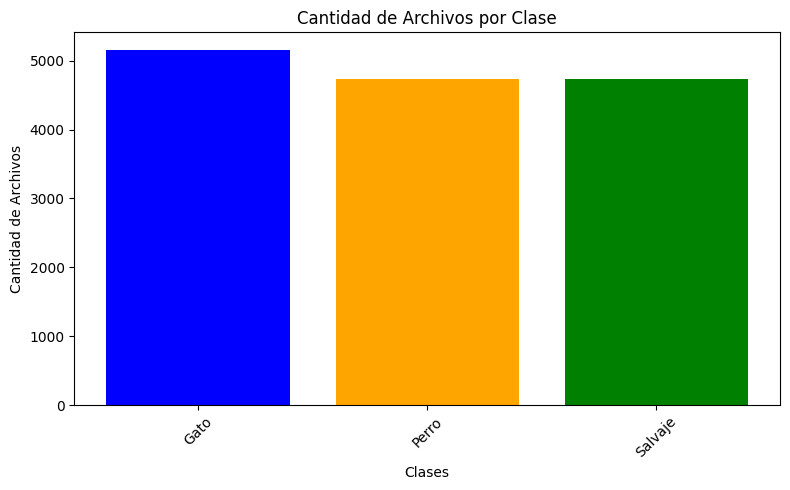

In [263]:
categories = ['Gato', 'Perro', 'Salvaje']
counts = [cat_count, dog_count, wild_count]

plt.figure(figsize=(8, 5))
plt.bar(categories, counts, color=['blue', 'orange', 'green'])
plt.xlabel('Clases')
plt.ylabel('Cantidad de Archivos')
plt.title('Cantidad de Archivos por Clase')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

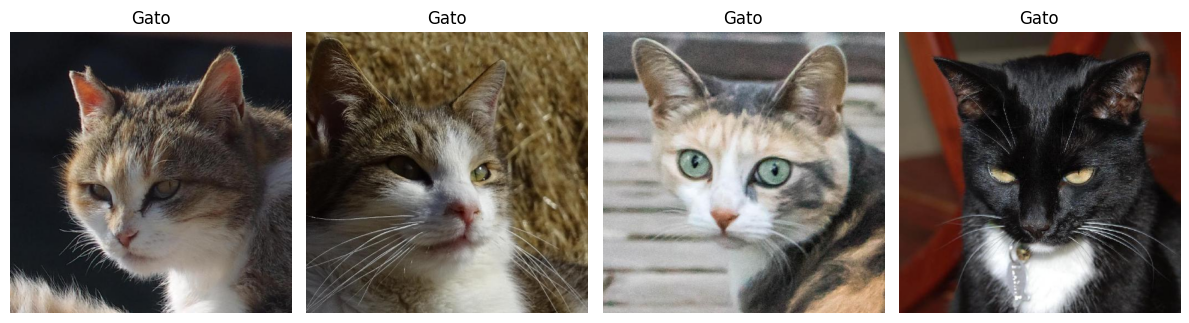

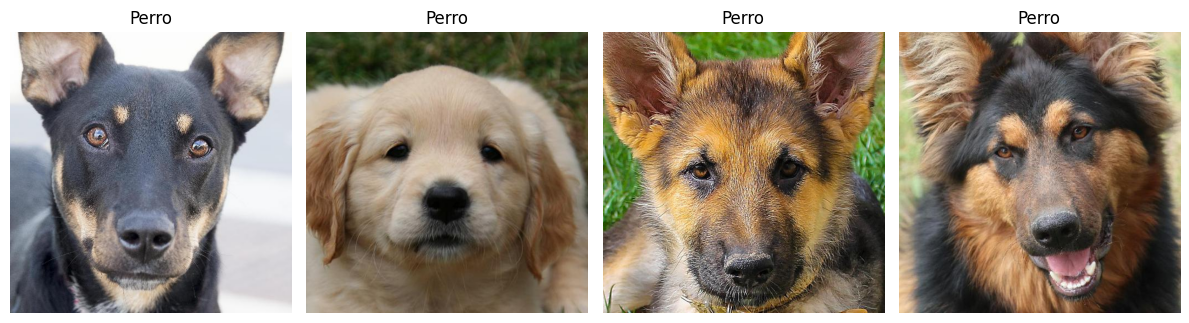

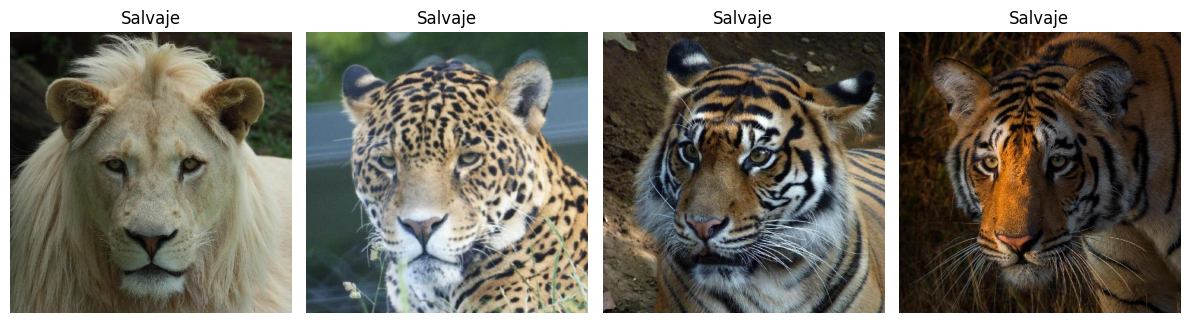

In [267]:
def display_images_from_directory(directory, title, num_images=4):
    images = os.listdir(directory)[:num_images]
    plt.figure(figsize=(12, 4))

    for i, image_name in enumerate(images):
        img_path = os.path.join(directory, image_name)
        img = mpimg.imread(img_path)

        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.title(title)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Mostrar imágenes de cada clase
display_images_from_directory(cat_dir, 'Gato')
display_images_from_directory(dog_dir, 'Perro')
display_images_from_directory(wild_dir, 'Salvaje')

##Modelo VAE (Gatos)

In [ ]:
import os
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms

cat_path = '/content/1/afhq/train/cat'
# Ruta donde se descomprimirán las imágenes
#dataset_path = '/content/data/cats'

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(root_dir) if f.endswith(('jpg', 'jpeg', 'png'))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')  # Convertir a escala de grises (modo 'L')
        if self.transform:
            image = self.transform(image)
        return image

In [ ]:
dataset = CustomImageDataset(root_dir=cat_path, transform=transform)

# Verificamos el número de imágenes en el dataset
print(f"El conjunto de datos tiene {len(dataset)} imágenes.")

El conjunto de datos tiene 5153 imágenes.


In [ ]:
batch_size = 64
train_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)

In [18]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Running on {DEVICE}")

Running on cuda


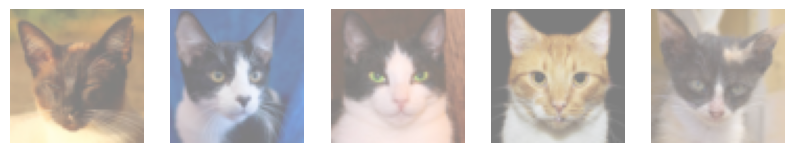

In [ ]:
import matplotlib.pyplot as plt

def show_sample_images(loader):
    images_iter = iter(loader)
    images = next(images_iter)

    plt.figure(figsize=(10, 5))
    for i in range(min(5, len(images))):  # Muestra hasta 5 imágenes
        plt.subplot(1, 5, i + 1)
        plt.imshow(images[i].permute(1, 2, 0) / 2 + 0.5)  # Desnormalizar para mostrar la imagen
        plt.axis('off')
    plt.show()

show_sample_images(train_loader)

In [ ]:
class VAE(nn.Module):
    def __init__(self, image_size=64, latent_dim=128, z_dim=2, device='cuda'):
        super(VAE, self).__init__()

        self.device = device
        self.latent_dim = latent_dim
        # Encoder
        self.encoder = nn.Sequential(
            # Capa convolucional 1
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),  # [B, 32, 32, 32]
            nn.LeakyReLU(0.2),
            # Capa convolucional 2
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # [B, 64, 16, 16]
            nn.LeakyReLU(0.2),
            # Aplanamos la salida para conectar con la capa densa
            nn.Flatten()
        )

        # El número de características después de la última capa convolucional
        flat_dim = 64 * (image_size // 4) * (image_size // 4)

        # Capa lineal para transformar la salida de la convolución en un espacio latente
        self.fc = nn.Linear(flat_dim, latent_dim)

        # Capa para calcular la media y log-varianza
        self.mean_layer = nn.Linear(latent_dim, z_dim)
        self.logvar_layer = nn.Linear(latent_dim, z_dim)

        # Decoder
        self.decoder_input = nn.Linear(z_dim, latent_dim)
        self.decoder_fc = nn.Linear(latent_dim, flat_dim)
        self.decoder_conv = nn.Sequential(
            # Capa transpuesta convolucional 1
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # [B, 32, 32, 32]
            nn.LeakyReLU(0.2),
            # Capa transpuesta convolucional 2
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),  # [B, 3, 64, 64]
            nn.Tanh()
        )

    def encode(self, x):
        h = self.encoder(x)
        h = self.fc(h)
        mean = self.mean_layer(h)
        logvar = self.logvar_layer(h)
        return mean, logvar

    def reparameterization(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mean + eps * std
        return z

    def decode(self, z):
        z = self.decoder_input(z)
        z = self.decoder_fc(z)
        z = z.view(z.size(0), 64, 16, 16)
        return self.decoder_conv(z)

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterization(mean, logvar)
        reconstructed_x = self.decode(z)
        return reconstructed_x, mean, logvar

In [ ]:
model = VAE(image_size=64, latent_dim=128, z_dim=2, device=DEVICE).to(DEVICE)

In [ ]:
from torchinfo import summary

In [ ]:
summary(model, input_size=(1, 3, 64, 64), col_names=('input_size', 'output_size', 'num_params'))

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
VAE                                      [1, 3, 64, 64]            [1, 3, 64, 64]            --
├─Sequential: 1-1                        [1, 3, 64, 64]            [1, 16384]                --
│    └─Conv2d: 2-1                       [1, 3, 64, 64]            [1, 32, 32, 32]           1,568
│    └─LeakyReLU: 2-2                    [1, 32, 32, 32]           [1, 32, 32, 32]           --
│    └─Conv2d: 2-3                       [1, 32, 32, 32]           [1, 64, 16, 16]           32,832
│    └─LeakyReLU: 2-4                    [1, 64, 16, 16]           [1, 64, 16, 16]           --
│    └─Flatten: 2-5                      [1, 64, 16, 16]           [1, 16384]                --
├─Linear: 1-2                            [1, 16384]                [1, 128]                  2,097,280
├─Linear: 1-3                            [1, 128]                  [1, 2]                    258
├─Linear: 1-4       

In [ ]:
import torch.nn.functional as F

def loss_function(x, x_hat, mean, log_var):
    reconstruction_loss = F.mse_loss(x_hat, x, reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    total_loss = reconstruction_loss + kl_divergence
    return total_loss

In [ ]:
def train(model, train_loader, optimizer, epochs, device):
    model.train()

    for epoch in range(epochs):
        overall_loss = 0

        for batch_idx, batch in enumerate(train_loader):

            if isinstance(batch, tuple):
                x, _ = batch
            else:
                x = batch

            x = x.to(device)

            optimizer.zero_grad()

            x_hat, mean, log_var = model(x)

            loss = loss_function(x, x_hat, mean, log_var)

            overall_loss += loss.item()

            loss.backward()
            optimizer.step()

        print(f"\tEpoch {epoch+1}/{epochs} \t Average Loss: {overall_loss / len(train_loader.dataset)}")

    return overall_loss

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
train(model, train_loader, optimizer, epochs=20, device=DEVICE)

	Epoch 1/20 	 Average Loss: 756.7483478222638
	Epoch 2/20 	 Average Loss: 485.42804043912525
	Epoch 3/20 	 Average Loss: 481.44053183521737
	Epoch 4/20 	 Average Loss: 481.24286690550406
	Epoch 5/20 	 Average Loss: 481.1601524597322
	Epoch 6/20 	 Average Loss: 480.19775077927903
	Epoch 7/20 	 Average Loss: 479.3101028451266
	Epoch 8/20 	 Average Loss: 479.1831093537745
	Epoch 9/20 	 Average Loss: 479.3554865642587
	Epoch 10/20 	 Average Loss: 479.2497587494542
	Epoch 11/20 	 Average Loss: 478.81685804992236
	Epoch 12/20 	 Average Loss: 479.40560679155345
	Epoch 13/20 	 Average Loss: 478.700260884133
	Epoch 14/20 	 Average Loss: 478.79243034245826
	Epoch 15/20 	 Average Loss: 477.8928191860324
	Epoch 16/20 	 Average Loss: 478.8178425719848
	Epoch 17/20 	 Average Loss: 478.8809708088735
	Epoch 18/20 	 Average Loss: 477.95866258126335
	Epoch 19/20 	 Average Loss: 477.6625554895207
	Epoch 20/20 	 Average Loss: 477.5644334156074


2460889.525390625

In [ ]:
def generate_image(z_dim=2, model=None, device='cuda'):

    z_sample = torch.randn(size=(1, z_dim)).to(device)
    x_decoded = model.decode(z_sample)
    digit = x_decoded.detach().cpu().reshape(3, 64, 64)
    plt.title(f'Latent Vector [{z_sample[0,0]:.2f}, {z_sample[0,1]:.2f}]')
    plt.imshow(digit.permute(1, 2, 0))
    plt.axis('off')
    plt.show()

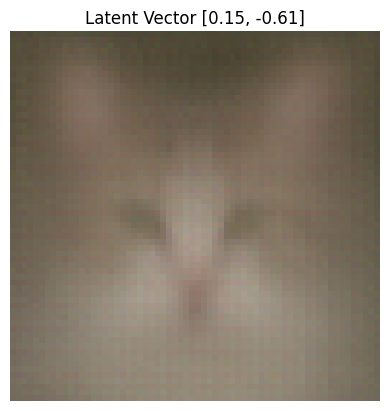

In [ ]:
generate_image(z_dim=2, model=model, device=DEVICE)

In [ ]:
def generate_images(z_dim=2, model=None, device='cuda', num_images=5):
    plt.figure(figsize=(15, 5))

    for i in range(num_images):
        z_sample = torch.randn(size=(1, z_dim)).to(device)
        x_decoded = model.decode(z_sample)
        digit = x_decoded.detach().cpu().reshape(3, 64, 64)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(digit.permute(1, 2, 0))
        plt.axis('off')

    plt.show()

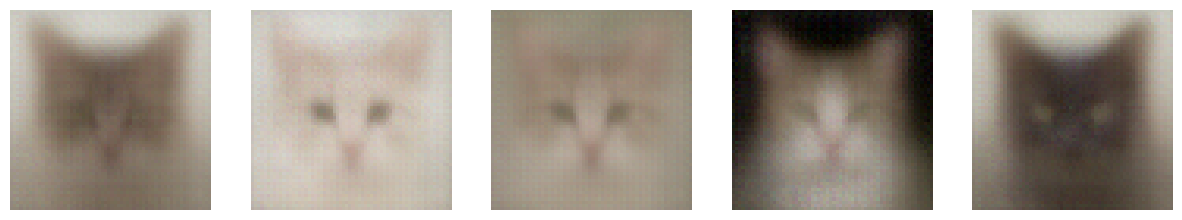

In [ ]:
generate_images(z_dim=2, model=model, device=DEVICE, num_images=5)

##Modelo VAE (Perros)

In [ ]:
# Ruta de las imágenes
dataset_path_dog = '/content/1/afhq/train/dog'


transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    #transforms.Normalize((0.5,), (0.5,))
])

class DogsDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(root_dir) if f.endswith(('jpg', 'jpeg', 'png'))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

In [ ]:
dataset = DogsDataset(root_dir=dataset_path_dog, transform=transform)

print(f"El conjunto de datos tiene {len(dataset)} imágenes.")

El conjunto de datos tiene 4739 imágenes.


In [ ]:
batch_size = 64
train_loader_dogs = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)

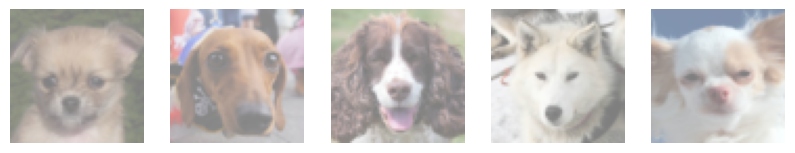

In [ ]:
show_sample_images(train_loader_dogs)

In [ ]:
model_dog = VAE(image_size=64, latent_dim=128, z_dim=2, device=DEVICE).to(DEVICE)

In [ ]:
optimizer = optim.Adam(model_dog.parameters(), lr=1e-3)

In [ ]:
train(model_dog, train_loader_dogs, optimizer, epochs=20, device=DEVICE)

	Epoch 1/20 	 Average Loss: 906.8455937279506
	Epoch 2/20 	 Average Loss: 549.2306590807742
	Epoch 3/20 	 Average Loss: 543.8269281493986
	Epoch 4/20 	 Average Loss: 542.9098474293677
	Epoch 5/20 	 Average Loss: 541.6861670148551
	Epoch 6/20 	 Average Loss: 541.6859838192311
	Epoch 7/20 	 Average Loss: 542.6497566785006
	Epoch 8/20 	 Average Loss: 541.247000764105
	Epoch 9/20 	 Average Loss: 539.9022207523756
	Epoch 10/20 	 Average Loss: 538.9875757459297
	Epoch 11/20 	 Average Loss: 541.205469424877
	Epoch 12/20 	 Average Loss: 539.221131311285
	Epoch 13/20 	 Average Loss: 539.5868094308036
	Epoch 14/20 	 Average Loss: 540.6527122277
	Epoch 15/20 	 Average Loss: 538.8191538237398
	Epoch 16/20 	 Average Loss: 538.6400590821343
	Epoch 17/20 	 Average Loss: 539.282060110008
	Epoch 18/20 	 Average Loss: 538.7618185905848
	Epoch 19/20 	 Average Loss: 538.1595832742602
	Epoch 20/20 	 Average Loss: 538.2300713968367


2550672.3083496094

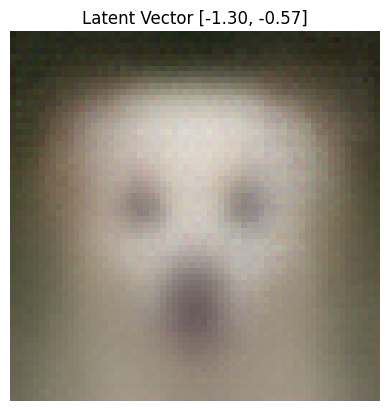

In [ ]:
generate_image(z_dim=2, model=model_dog, device=DEVICE)

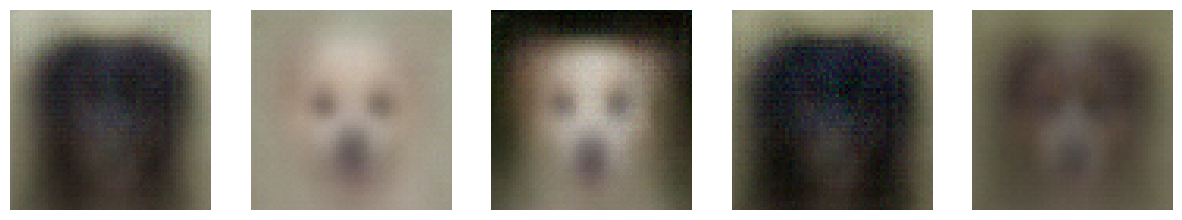

In [ ]:
generate_images(z_dim=2, model=model_dog, device=DEVICE, num_images=5)

##Modelo CVAE (Gatos + Perros)

In [ ]:
class CVAE(nn.Module):
    def __init__(self, image_size=64, latent_dim=128, z_dim=2, num_classes=2, device='cuda'):
        super(CVAE, self).__init__()

        self.device = device
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),  # [B, 32, 32, 32]
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # [B, 64, 16, 16]
            nn.LeakyReLU(0.2),
            nn.Flatten()
        )

        flat_dim = 64 * (image_size // 4) * (image_size // 4)

        self.fc = nn.Linear(flat_dim + num_classes, latent_dim)  # Concatenar la clase
        self.mean_layer = nn.Linear(latent_dim, z_dim)
        self.logvar_layer = nn.Linear(latent_dim, z_dim)

        # Decoder
        self.decoder_input = nn.Linear(z_dim + num_classes, latent_dim)  # Concatenar la clase
        self.decoder_fc = nn.Linear(latent_dim, flat_dim)
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # [B, 32, 32, 32]
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),  # [B, 3, 64, 64]
            nn.Tanh()
        )

    def encode(self, x, labels):
        h = self.encoder(x)
        h = torch.cat((h, labels), dim=-1)  # Concatenar las etiquetas
        h = self.fc(h)
        mean = self.mean_layer(h)
        logvar = self.logvar_layer(h)
        return mean, logvar

    def reparameterization(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mean + eps * std
        return z

    def decode(self, z, labels):
        z = torch.cat((z, labels), dim=-1)  # Concatenar las etiquetas
        z = self.decoder_input(z)
        z = self.decoder_fc(z)
        z = z.view(z.size(0), 64, 16, 16)
        return self.decoder_conv(z)

    def forward(self, x, labels):
        mean, logvar = self.encode(x, labels)
        z = self.reparameterization(mean, logvar)
        reconstructed_x = self.decode(z, labels)
        return reconstructed_x, mean, logvar

In [ ]:
def loss_function(x_hat, x, mean, log_var):
    reconstruction_loss = F.mse_loss(x_hat.view(-1), x.view(-1), reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    total_loss = reconstruction_loss + kl_divergence
    return total_loss

In [ ]:
# Crear transformaciones para las imágenes
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


In [ ]:
from torchvision.datasets import ImageFolder

dataset = ImageFolder(root='/content/1/afhq/train', transform=transform)
train_loader = DataLoader(dataset=dataset,
                          batch_size=64,
                          shuffle=True)

In [ ]:
def show_sample_images_2(loader):
    images_iter = iter(loader)
    images, labels = next(images_iter)

    plt.figure(figsize=(10, 5))
    for i in range(min(5, images.size(0))):
        plt.subplot(1, 5, i + 1)
        plt.imshow(images[i].permute(1, 2, 0) / 2 + 0.5)
        plt.axis('off')
    plt.show()

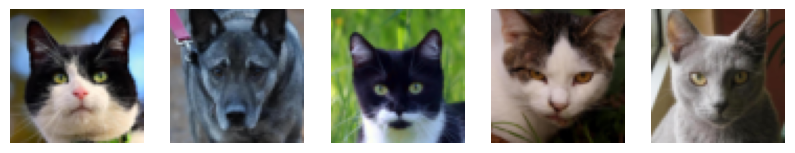

In [ ]:
show_sample_images_2(train_loader)

In [ ]:
# Inicializar el modelo y el optimizador
model = CVAE(image_size=64,
             latent_dim=128,
             z_dim=2,
             num_classes=2,
             device=DEVICE).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
def train(model, train_loader, optimizer, epochs, device):
    model.train()

    for epoch in range(epochs):
        overall_loss = 0
        for batch_idx, batch in enumerate(train_loader):
            x, labels = batch
            x = x.to(device)
            labels = F.one_hot(labels, num_classes=2).float().to(device)
            optimizer.zero_grad()
            x_hat, mean, log_var = model(x, labels)
            loss = loss_function(x_hat, x, mean, log_var)
            overall_loss += loss.item()
            loss.backward()
            optimizer.step()

        print(f"\tEpoch {epoch+1}/{epochs} \t Average Loss: {overall_loss / len(train_loader.dataset)}")

    return overall_loss

In [ ]:
# Entrenamiento del modelo
train(model=model,
      train_loader=train_loader,
      optimizer=optimizer,
      epochs=20,
      device=DEVICE)

	Epoch 1/20 	 Average Loss: 2155.1172980691467
	Epoch 2/20 	 Average Loss: 2024.5381818957237
	Epoch 3/20 	 Average Loss: 2016.1618258441165
	Epoch 4/20 	 Average Loss: 2013.4966995109685
	Epoch 5/20 	 Average Loss: 2011.6347371929337
	Epoch 6/20 	 Average Loss: 2008.3355481386475
	Epoch 7/20 	 Average Loss: 2008.1934620463505
	Epoch 8/20 	 Average Loss: 2004.2625567061766
	Epoch 9/20 	 Average Loss: 2003.387641212596
	Epoch 10/20 	 Average Loss: 2002.6329258333756
	Epoch 11/20 	 Average Loss: 2001.8176114537
	Epoch 12/20 	 Average Loss: 2000.3460008719167
	Epoch 13/20 	 Average Loss: 1999.6923863665083
	Epoch 14/20 	 Average Loss: 1999.6055666826728
	Epoch 15/20 	 Average Loss: 1998.693018979984
	Epoch 16/20 	 Average Loss: 1998.1254225320965
	Epoch 17/20 	 Average Loss: 1996.6505793823292
	Epoch 18/20 	 Average Loss: 1996.923913421199
	Epoch 19/20 	 Average Loss: 1996.1442698329458
	Epoch 20/20 	 Average Loss: 1995.0763843257178


19735295.59375

In [ ]:
def generate_image(model, label):
    model.eval()

    with torch.no_grad():
        z = torch.randn(1, 2).to(DEVICE)
        label_tensor = torch.zeros((1,2)).to(DEVICE)
        label_tensor[0][label] = 1.0

        generated_image = model.decode(z,z).cpu().squeeze().permute(1 ,2 ,0).numpy()

    return generated_image

In [ ]:
# Generar una imagen de un gato (etiqueta: 0) o perro (etiqueta: 1)
generated_cat_image = generate_image(model=model,label=0)   # Gato
generated_dog_image = generate_image(model=model,label=1)   # Perro

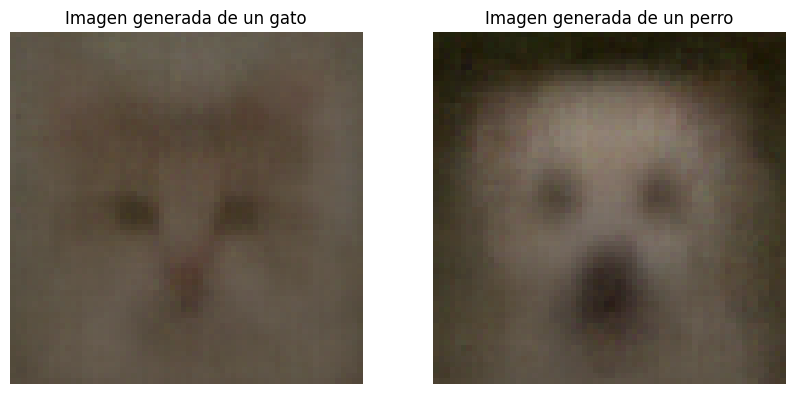

In [ ]:
plt.figure(figsize=(10 ,5))
plt.subplot(1 ,2 ,1)
plt.imshow((generated_cat_image + 0.5) / 2)
plt.title('Imagen generada de un gato')
plt.axis('off')

plt.subplot(1 ,2 ,2)
plt.imshow((generated_dog_image + 0.5) / 2)
plt.title('Imagen generada de un perro')
plt.axis('off')

plt.show()

##CVAE con Dropout

In [ ]:
class CVAE(nn.Module):
    def __init__(self, image_size=64, latent_dim=128, z_dim=2, num_classes=2, device='cuda', dropout_rate=0.3):
        super(CVAE, self).__init__()

        self.device = device
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),  # [B, 32, 32, 32]
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # [B, 64, 16, 16]
            nn.LeakyReLU(0.2),
            nn.Flatten()
        )

        flat_dim = 64 * (image_size // 4) * (image_size // 4)

        self.fc = nn.Linear(flat_dim + num_classes, latent_dim)  # Concatenar la clase
        self.mean_layer = nn.Linear(latent_dim, z_dim)
        self.logvar_layer = nn.Linear(latent_dim, z_dim)

        # Decoder
        self.decoder_input = nn.Linear(z_dim + num_classes, latent_dim)  # Concatenar la clase
        self.decoder_fc = nn.Linear(latent_dim, flat_dim)

        # Agregar Dropout después de las capas densas
        self.dropout = nn.Dropout(dropout_rate)

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # [B, 32, 32, 32]
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),  # [B, 3, 64, 64]
            nn.Tanh()
        )

    def encode(self, x, labels):
        h = self.encoder(x)
        h = torch.cat((h, labels), dim=-1)
        h = self.fc(h)

        h = self.dropout(h)

        mean = self.mean_layer(h)
        logvar = self.logvar_layer(h)
        return mean, logvar

    def reparameterization(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mean + eps * std
        return z

    def decode(self, z, labels):
        z = torch.cat((z, labels), dim=-1)
        z = self.decoder_input(z)

        z = self.dropout(z)

        z = self.decoder_fc(z)
        z = z.view(z.size(0), 64, 16, 16)

        return self.decoder_conv(z)

    def forward(self, x, labels):
        mean, logvar = self.encode(x, labels)
        z = self.reparameterization(mean, logvar)
        reconstructed_x = self.decode(z, labels)
        return reconstructed_x, mean, logvar

In [ ]:
# Inicializar el modelo y el optimizador
model = CVAE(image_size=64,
             latent_dim=128,
             z_dim=2,
             num_classes=2,
             device=DEVICE).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
dummy_labels = torch.tensor([[1, 0]])

summary(model, input_size=[(1, 3, 64, 64), (1, 2)], col_names=('input_size', 'output_size', 'num_params'))

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
CVAE                                     [1, 3, 64, 64]            [1, 3, 64, 64]            --
├─Sequential: 1-1                        [1, 3, 64, 64]            [1, 16384]                --
│    └─Conv2d: 2-1                       [1, 3, 64, 64]            [1, 32, 32, 32]           1,568
│    └─LeakyReLU: 2-2                    [1, 32, 32, 32]           [1, 32, 32, 32]           --
│    └─Conv2d: 2-3                       [1, 32, 32, 32]           [1, 64, 16, 16]           32,832
│    └─LeakyReLU: 2-4                    [1, 64, 16, 16]           [1, 64, 16, 16]           --
│    └─Flatten: 2-5                      [1, 64, 16, 16]           [1, 16384]                --
├─Linear: 1-2                            [1, 16386]                [1, 128]                  2,097,536
├─Dropout: 1-3                           [1, 128]                  [1, 128]                  --
├─Linear: 1-4        

In [ ]:
# Entrenamiento del modelo
train(model=model,
      train_loader=train_loader,
      optimizer=optimizer,
      epochs=20,
      device=DEVICE)

	Epoch 1/20 	 Average Loss: 2192.1277760753637
	Epoch 2/20 	 Average Loss: 2055.231397530833
	Epoch 3/20 	 Average Loss: 2042.9347752603114
	Epoch 4/20 	 Average Loss: 2040.3477715578244
	Epoch 5/20 	 Average Loss: 2033.5565632265973
	Epoch 6/20 	 Average Loss: 2030.731536532046
	Epoch 7/20 	 Average Loss: 2029.3573910735947
	Epoch 8/20 	 Average Loss: 2026.532735575465
	Epoch 9/20 	 Average Loss: 2026.0376953914779
	Epoch 10/20 	 Average Loss: 2025.2858346706935
	Epoch 11/20 	 Average Loss: 2024.8560618744946
	Epoch 12/20 	 Average Loss: 2021.379361163061
	Epoch 13/20 	 Average Loss: 2020.9050819159422
	Epoch 14/20 	 Average Loss: 2021.1825536102406
	Epoch 15/20 	 Average Loss: 2019.408622497978
	Epoch 16/20 	 Average Loss: 2019.164951791852
	Epoch 17/20 	 Average Loss: 2018.549632120653
	Epoch 18/20 	 Average Loss: 2018.0700226508795
	Epoch 19/20 	 Average Loss: 2017.8113453421956
	Epoch 20/20 	 Average Loss: 2018.6650047070866


19968634.2265625

In [ ]:
# Generar una imagen de un gato (etiqueta: 0) o perro (etiqueta: 1)
generated_cat_image_dropout = generate_image(model=model,label=0)   # Gato
generated_dog_image_dropout = generate_image(model=model,label=1)   # Perro

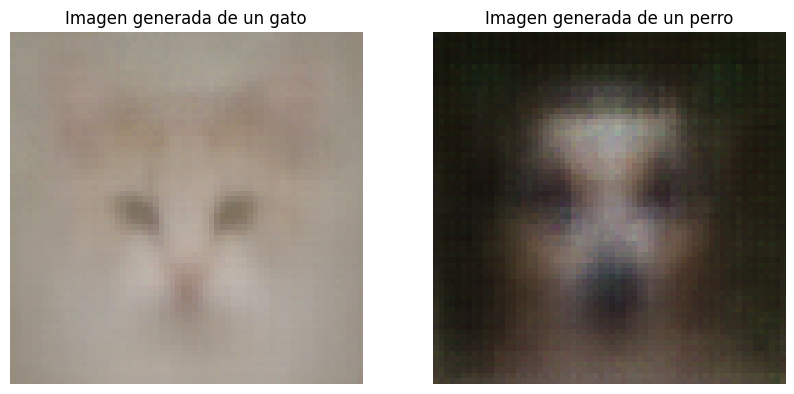

In [ ]:
plt.figure(figsize=(10 ,5))
plt.subplot(1 ,2 ,1)
plt.imshow((generated_cat_image_dropout + 1) / 2)
plt.title('Imagen generada de un gato')
plt.axis('off')

plt.subplot(1 ,2 ,2)
plt.imshow((generated_dog_image_dropout +1) / 2)
plt.title('Imagen generada de un perro')
plt.axis('off')

plt.show()

##CVAE con Dropout + BatchNorm

In [ ]:
class CVAE(nn.Module):
    def __init__(self, image_size=64, latent_dim=128, z_dim=2, num_classes=2, device='cuda', dropout_rate=0.3):
        super(CVAE, self).__init__()

        self.device = device
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),  # [B, 32, 32, 32]
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # [B, 64, 16, 16]
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(64),
            nn.Flatten()
        )

        flat_dim = 64 * (image_size // 4) * (image_size // 4)

        self.fc = nn.Linear(flat_dim + num_classes, latent_dim)
        self.mean_layer = nn.Linear(latent_dim, z_dim)
        self.logvar_layer = nn.Linear(latent_dim, z_dim)

        # Decoder
        self.decoder_input = nn.Linear(z_dim + num_classes, latent_dim)
        self.decoder_fc = nn.Linear(latent_dim, flat_dim)


        self.dropout = nn.Dropout(dropout_rate)

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # [B, 32, 32, 32]
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),  # [B, 3, 64, 64]
            nn.Tanh()
        )

    def encode(self, x, labels):
        h = self.encoder(x)
        h = torch.cat((h, labels), dim=-1)
        h = self.fc(h)

        h = self.dropout(h)

        mean = self.mean_layer(h)
        logvar = self.logvar_layer(h)
        return mean, logvar

    def reparameterization(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mean + eps * std
        return z

    def decode(self, z, labels):
        z = torch.cat((z, labels), dim=-1)
        z = self.decoder_input(z)

        z = self.dropout(z)

        z = self.decoder_fc(z)

        z = z.view(z.size(0), 64, 16, 16)

        return self.decoder_conv(z)

    def forward(self, x, labels):
        mean, logvar = self.encode(x, labels)
        z = self.reparameterization(mean, logvar)
        reconstructed_x = self.decode(z, labels)
        return reconstructed_x, mean, logvar

In [ ]:
# Inicializar el modelo y el optimizador
model = CVAE(image_size=64,
             latent_dim=128,
             z_dim=2,
             num_classes=2,
             device=DEVICE).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
dummy_labels = torch.tensor([[1, 0]])
summary(model, input_size=[(1, 3, 64, 64), (1, 2)], col_names=('input_size', 'output_size', 'num_params'))

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
CVAE                                     [1, 3, 64, 64]            [1, 3, 64, 64]            --
├─Sequential: 1-1                        [1, 3, 64, 64]            [1, 16384]                --
│    └─Conv2d: 2-1                       [1, 3, 64, 64]            [1, 32, 32, 32]           1,568
│    └─LeakyReLU: 2-2                    [1, 32, 32, 32]           [1, 32, 32, 32]           --
│    └─BatchNorm2d: 2-3                  [1, 32, 32, 32]           [1, 32, 32, 32]           64
│    └─Conv2d: 2-4                       [1, 32, 32, 32]           [1, 64, 16, 16]           32,832
│    └─LeakyReLU: 2-5                    [1, 64, 16, 16]           [1, 64, 16, 16]           --
│    └─BatchNorm2d: 2-6                  [1, 64, 16, 16]           [1, 64, 16, 16]           128
│    └─Flatten: 2-7                      [1, 64, 16, 16]           [1, 16384]                --
├─Linear: 1-2              

In [ ]:
# Entrenamiento del modelo
train(model=model,
      train_loader=train_loader,
      optimizer=optimizer,
      epochs=20,
      device=DEVICE)

	Epoch 1/20 	 Average Loss: 4420.3742907779015
	Epoch 2/20 	 Average Loss: 3084.3570641048323
	Epoch 3/20 	 Average Loss: 2437.985359855186
	Epoch 4/20 	 Average Loss: 2282.032712671856
	Epoch 5/20 	 Average Loss: 2215.136815892893
	Epoch 6/20 	 Average Loss: 2174.4220171603315
	Epoch 7/20 	 Average Loss: 2152.3132408132833
	Epoch 8/20 	 Average Loss: 2136.439994913819
	Epoch 9/20 	 Average Loss: 2123.0022571901536
	Epoch 10/20 	 Average Loss: 2114.1760718889
	Epoch 11/20 	 Average Loss: 2102.518579960448
	Epoch 12/20 	 Average Loss: 2097.8871002135566
	Epoch 13/20 	 Average Loss: 2091.0230899969674
	Epoch 14/20 	 Average Loss: 2083.9989582806816
	Epoch 15/20 	 Average Loss: 2080.9813225017692
	Epoch 16/20 	 Average Loss: 2076.758862117115
	Epoch 17/20 	 Average Loss: 2072.033186539628
	Epoch 18/20 	 Average Loss: 2068.2351071257076
	Epoch 19/20 	 Average Loss: 2065.678505199909
	Epoch 20/20 	 Average Loss: 2064.920519738172


20426193.78125

In [ ]:
# Generar una imagen de un gato (etiqueta: 0) o perro (etiqueta: 1)
generated_cat_image_dropBN = generate_image(model=model,label=0)   # Gato
generated_dog_image_dropBN = generate_image(model=model,label=1)   # Perro

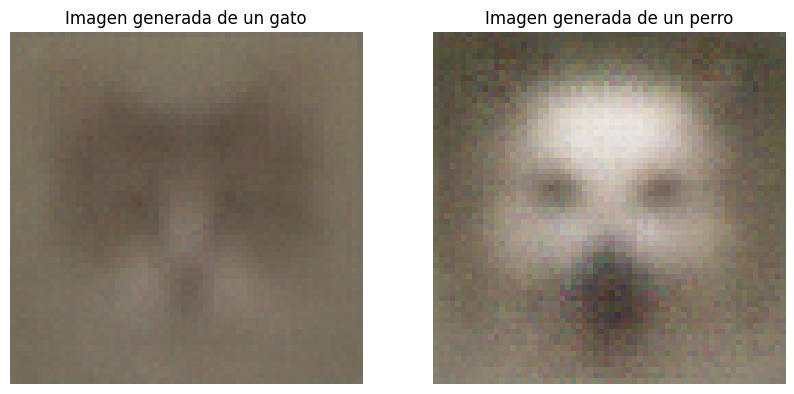

In [ ]:
plt.figure(figsize=(10 ,5))
plt.subplot(1 ,2 ,1)
plt.imshow((generated_cat_image_dropBN + 1) / 2)
plt.title('Imagen generada de un gato')
plt.axis('off')

plt.subplot(1 ,2 ,2)
plt.imshow((generated_dog_image_dropBN + 1) / 2)
plt.title('Imagen generada de un perro')
plt.axis('off')

plt.show()

##CVAE con BatchNorm

In [ ]:
class CVAE(nn.Module):
    def __init__(self, image_size=64, latent_dim=128, z_dim=2, num_classes=2, device='cuda'):
        super(CVAE, self).__init__()

        self.device = device
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),  # [B, 32, 32, 32]
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # [B, 64, 16, 16]
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(64),
            nn.Flatten()
        )

        flat_dim = 64 * (image_size // 4) * (image_size // 4)

        self.fc = nn.Linear(flat_dim + num_classes, latent_dim)
        self.mean_layer = nn.Linear(latent_dim, z_dim)
        self.logvar_layer = nn.Linear(latent_dim, z_dim)

        # Decoder
        self.decoder_input = nn.Linear(z_dim + num_classes, latent_dim)
        self.decoder_fc = nn.Linear(latent_dim, flat_dim)

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # [B, 32, 32, 32]
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),  # [B, 3, 64, 64]
            nn.Tanh()
        )

    def encode(self, x, labels):
        h = self.encoder(x)
        h = torch.cat((h, labels), dim=-1)
        h = self.fc(h)

        mean = self.mean_layer(h)
        logvar = self.logvar_layer(h)
        return mean, logvar

    def reparameterization(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mean + eps * std
        return z

    def decode(self, z, labels):
        z = torch.cat((z, labels), dim=-1)
        z = self.decoder_input(z)

        z = self.decoder_fc(z)

        z = z.view(z.size(0), 64, 16, 16)

        return self.decoder_conv(z)

    def forward(self, x, labels):
        mean, logvar = self.encode(x, labels)
        z = self.reparameterization(mean, logvar)
        reconstructed_x = self.decode(z, labels)
        return reconstructed_x, mean, logvar

In [ ]:
# Inicializar el modelo y el optimizador
model = CVAE(image_size=64,
             latent_dim=128,
             z_dim=2,
             num_classes=2,
             device=DEVICE).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
dummy_labels = torch.tensor([[1, 0]])
summary(model, input_size=[(1, 3, 64, 64), (1, 2)], col_names=('input_size', 'output_size', 'num_params'))

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
CVAE                                     [1, 3, 64, 64]            [1, 3, 64, 64]            --
├─Sequential: 1-1                        [1, 3, 64, 64]            [1, 16384]                --
│    └─Conv2d: 2-1                       [1, 3, 64, 64]            [1, 32, 32, 32]           1,568
│    └─LeakyReLU: 2-2                    [1, 32, 32, 32]           [1, 32, 32, 32]           --
│    └─BatchNorm2d: 2-3                  [1, 32, 32, 32]           [1, 32, 32, 32]           64
│    └─Conv2d: 2-4                       [1, 32, 32, 32]           [1, 64, 16, 16]           32,832
│    └─LeakyReLU: 2-5                    [1, 64, 16, 16]           [1, 64, 16, 16]           --
│    └─BatchNorm2d: 2-6                  [1, 64, 16, 16]           [1, 64, 16, 16]           128
│    └─Flatten: 2-7                      [1, 64, 16, 16]           [1, 16384]                --
├─Linear: 1-2              

In [ ]:
# Entrenamiento del modelo
train(model=model,
      train_loader=train_loader,
      optimizer=optimizer,
      epochs=20,
      device=DEVICE)

	Epoch 1/20 	 Average Loss: 4699.037409491256
	Epoch 2/20 	 Average Loss: 3036.142596289931
	Epoch 3/20 	 Average Loss: 2450.1475829584515
	Epoch 4/20 	 Average Loss: 2235.3270682748685
	Epoch 5/20 	 Average Loss: 2160.009337564446
	Epoch 6/20 	 Average Loss: 2122.823879934543
	Epoch 7/20 	 Average Loss: 2104.116318742418
	Epoch 8/20 	 Average Loss: 2093.608622340022
	Epoch 9/20 	 Average Loss: 2083.3989405896177
	Epoch 10/20 	 Average Loss: 2073.6855026473413
	Epoch 11/20 	 Average Loss: 2067.973007701931
	Epoch 12/20 	 Average Loss: 2062.9372914981805
	Epoch 13/20 	 Average Loss: 2059.357571933128
	Epoch 14/20 	 Average Loss: 2054.6247859697232
	Epoch 15/20 	 Average Loss: 2051.8096465262333
	Epoch 16/20 	 Average Loss: 2048.1627925343714
	Epoch 17/20 	 Average Loss: 2041.7638551038717
	Epoch 18/20 	 Average Loss: 2041.7919586218661
	Epoch 19/20 	 Average Loss: 2042.4334444816518
	Epoch 20/20 	 Average Loss: 2039.095815273706


20170735.8046875

In [ ]:
# Generar una imagen de un gato (etiqueta: 0) o perro (etiqueta: 1)
generated_cat_image_BN = generate_image(model=model,label=0)   # Gato
generated_dog_image_BN = generate_image(model=model,label=1)   # Perro

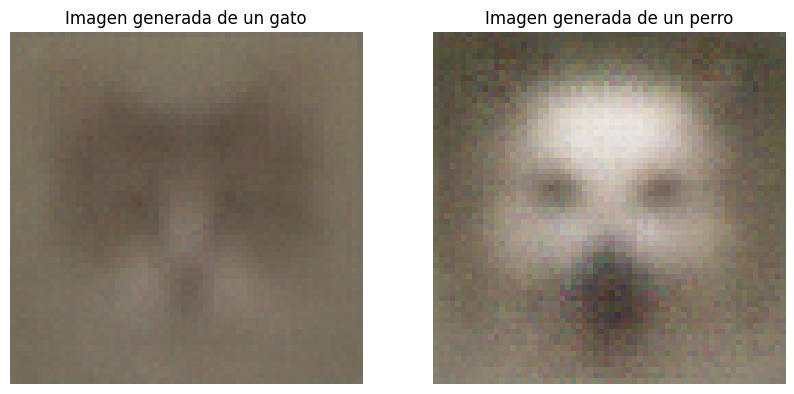

In [ ]:
plt.figure(figsize=(10 ,5))
plt.subplot(1 ,2 ,1)
plt.imshow((generated_cat_image_dropBN + 1) / 2)
plt.title('Imagen generada de un gato')
plt.axis('off')

plt.subplot(1 ,2 ,2)
plt.imshow((generated_dog_image_dropBN + 1) / 2)
plt.title('Imagen generada de un perro')
plt.axis('off')

plt.show()

##Modelo CVAE (Gatos + Perros + Animales salvajes)

In [216]:
class CVAE(nn.Module):
    def __init__(self, image_size=64, latent_dim=128, z_dim=2, num_classes=3, device='cuda'):
        super(CVAE, self).__init__()

        self.device = device
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),  # [B, 32, 32, 32]
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # [B, 64, 16, 16]
            nn.LeakyReLU(0.2),
            nn.Flatten()
        )

        flat_dim = 64 * (image_size // 4) * (image_size // 4)

        self.fc = nn.Linear(flat_dim + num_classes, latent_dim)
        self.mean_layer = nn.Linear(latent_dim, z_dim)
        self.logvar_layer = nn.Linear(latent_dim, z_dim)

        # Decoder
        self.decoder_input = nn.Linear(z_dim + num_classes, latent_dim)
        self.decoder_fc = nn.Linear(latent_dim, flat_dim)
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def encode(self, x, labels):
        h = self.encoder(x)
        h = torch.cat((h, labels), dim=-1)
        h = self.fc(h)
        mean = self.mean_layer(h)
        logvar = self.logvar_layer(h)
        return mean, logvar

    def reparameterization(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mean + eps * std
        return z

    def decode(self, z, labels):
        z = torch.cat((z, labels), dim=-1)
        z = self.decoder_input(z)
        z = self.decoder_fc(z)
        z = z.view(z.size(0), 64, 16, 16)
        return self.decoder_conv(z)

    def forward(self, x, labels):
        mean, logvar = self.encode(x, labels)
        z = self.reparameterization(mean, logvar)
        reconstructed_x = self.decode(z, labels)
        return reconstructed_x, mean, logvar

In [37]:
def loss_function(x_hat, x, mean, log_var):
    reconstruction_loss = F.mse_loss(x_hat.view(-1), x.view(-1), reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    total_loss = reconstruction_loss + kl_divergence
    return total_loss

In [10]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


In [11]:
from torchvision.datasets import ImageFolder

dataset = ImageFolder(root='/content/data/afhq/train', transform=transform)
train_loader = DataLoader(dataset=dataset,
                          batch_size=64,
                          shuffle=True)

In [12]:
def show_sample_images_3(loader):
    images_iter = iter(loader)
    images, labels = next(images_iter)

    plt.figure(figsize=(10, 5))
    for i in range(min(5, images.size(0))):
        plt.subplot(1, 5, i + 1)
        plt.imshow(images[i].permute(1, 2, 0) / 2 + 0.5)
        plt.axis('off')
    plt.show()

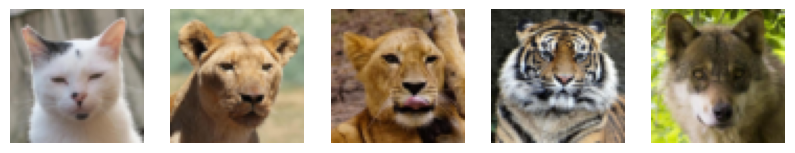

In [15]:
show_sample_images_3(train_loader)

In [241]:
# Inicializar el modelo y el optimizador
model = CVAE(image_size=64,
             latent_dim=128,
             z_dim=2,
             num_classes=3,
             device=DEVICE).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [34]:
def train(model, train_loader, optimizer, epochs, device):
    model.train()

    for epoch in range(epochs):
        overall_loss = 0

        for batch_idx, batch in enumerate(train_loader):

            x, labels = batch
            x = x.to(device)
            labels = F.one_hot(labels, num_classes=3).float().to(device)
            optimizer.zero_grad()
            x_hat, mean, log_var = model(x, labels)
            loss = loss_function(x_hat, x, mean, log_var)
            overall_loss += loss.item()
            loss.backward()
            optimizer.step()

        print(f"\tEpoch {epoch+1}/{epochs} \t Average Loss: {overall_loss / len(train_loader.dataset)}")

    return overall_loss

In [242]:
# Entrenamiento del modelo
train(model=model,
      train_loader=train_loader,
      optimizer=optimizer,
      epochs=20,
      device=DEVICE)

	Epoch 1/20 	 Average Loss: 1964.2691665242653
	Epoch 2/20 	 Average Loss: 1875.9715855690363
	Epoch 3/20 	 Average Loss: 1871.6094203904647
	Epoch 4/20 	 Average Loss: 1868.1700230690362
	Epoch 5/20 	 Average Loss: 1864.8991236970267
	Epoch 6/20 	 Average Loss: 1863.6064390379358
	Epoch 7/20 	 Average Loss: 1863.0354990815106
	Epoch 8/20 	 Average Loss: 1860.3959917549555
	Epoch 9/20 	 Average Loss: 1859.6713223043405
	Epoch 10/20 	 Average Loss: 1859.1225718771361
	Epoch 11/20 	 Average Loss: 1857.6363791225222
	Epoch 12/20 	 Average Loss: 1857.1915776657554
	Epoch 13/20 	 Average Loss: 1856.0563642771701
	Epoch 14/20 	 Average Loss: 1856.1344892771701
	Epoch 15/20 	 Average Loss: 1855.7582156741285
	Epoch 16/20 	 Average Loss: 1854.9639866712234
	Epoch 17/20 	 Average Loss: 1854.4317346099624
	Epoch 18/20 	 Average Loss: 1854.2123179041353
	Epoch 19/20 	 Average Loss: 1853.379980669002
	Epoch 20/20 	 Average Loss: 1853.4990056818183


27116690.453125

In [35]:
def generate_images_2(model, label):
  model.eval()

  with torch.no_grad():
      z = torch.randn(1, 2).to(DEVICE)
      label_tensor = torch.zeros((1, 3)).to(DEVICE)
      label_tensor[0][label] = 1.0
      generated_image = model.decode(z, label_tensor).cpu().squeeze().permute(1, 2, 0).numpy()

  return generated_image

In [256]:
# Generar una imagen de un gato (etiqueta: 0) o perro (etiqueta: 1) o wild (etiqueta: 2)
generated_cat_image = generate_images_2(model=model,label=0)   # Gato
generated_dog_image = generate_images_2(model=model,label=1)   # Perro
generated_wild_image = generate_images_2(model=model,label=2)   # Wild

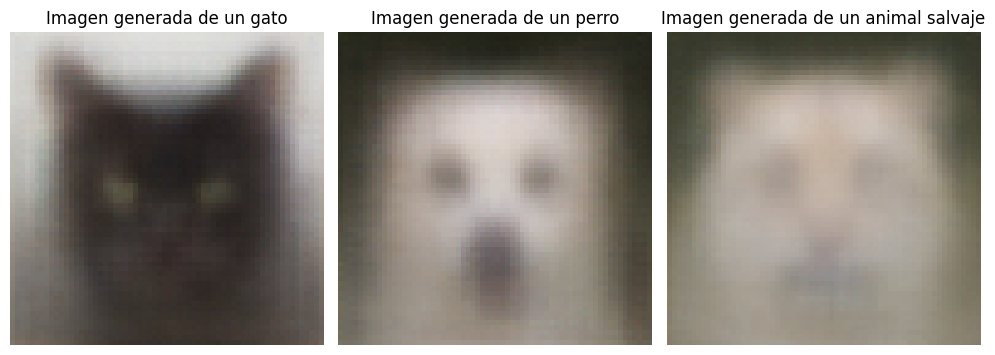

In [259]:
plt.figure(figsize=(10 ,5))
plt.subplot(1 ,3 ,1)
plt.imshow((generated_cat_image +1) / 2)
plt.title('Imagen generada de un gato')
plt.axis('off')

plt.subplot(1 ,3 ,2)
plt.imshow((generated_dog_image +1) / 2)
plt.title('Imagen generada de un perro')
plt.axis('off')

plt.subplot(1 ,3 ,3)
plt.imshow((generated_wild_image + 1) / 2)
plt.title('Imagen generada de un animal salvaje')
plt.axis('off')

plt.tight_layout()

plt.show()

##Modelo CVAE (Gatos + Perros + Animales salvajes) - Cambio ENCODER

In [31]:
class CVAE(nn.Module):
    def __init__(self, image_size=64, latent_dim=128, z_dim=2, num_classes=3, device='cuda'):
        super(CVAE, self).__init__()

        self.device = device
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),  # [B, 32, 32, 32]
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # [B, 64, 16, 16]
            nn.LeakyReLU(0.2),
            nn.Flatten()
        )

        flat_dim = 64 * (image_size // 4) * (image_size // 4)

        self.fc = nn.Linear(flat_dim, latent_dim)
        self.mean_layer = nn.Linear(latent_dim, z_dim)
        self.logvar_layer = nn.Linear(latent_dim, z_dim)

        # Decoder
        self.decoder_input = nn.Linear(z_dim + num_classes, latent_dim)
        self.decoder_fc = nn.Linear(latent_dim, flat_dim)
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def encode(self, x, labels):
        h = self.encoder(x)
        #h = torch.cat((h, labels), dim=-1)
        h = self.fc(h)
        mean = self.mean_layer(h)
        logvar = self.logvar_layer(h)
        return mean, logvar

    def reparameterization(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mean + eps * std
        return z

    def decode(self, z, labels):
        z = torch.cat((z, labels), dim=-1)
        z = self.decoder_input(z)
        z = self.decoder_fc(z)
        z = z.view(z.size(0), 64, 16, 16)
        return self.decoder_conv(z)

    def forward(self, x, labels):
        mean, logvar = self.encode(x, labels)
        z = self.reparameterization(mean, logvar)
        reconstructed_x = self.decode(z, labels)
        return reconstructed_x, mean, logvar

In [32]:
# Inicializar el modelo y el optimizador
model = CVAE(image_size=64,
             latent_dim=128,
             z_dim=2,
             num_classes=3,
             device=DEVICE).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [38]:
# Entrenamiento del modelo
train(model=model,
      train_loader=train_loader,
      optimizer=optimizer,
      epochs=20,
      device=DEVICE)

	Epoch 1/20 	 Average Loss: 1942.9300431476418
	Epoch 2/20 	 Average Loss: 1875.8008186303828
	Epoch 3/20 	 Average Loss: 1869.8489853896103
	Epoch 4/20 	 Average Loss: 1867.5243426392685
	Epoch 5/20 	 Average Loss: 1864.8586546266233
	Epoch 6/20 	 Average Loss: 1863.710465439166
	Epoch 7/20 	 Average Loss: 1862.0854392728982
	Epoch 8/20 	 Average Loss: 1860.7973897812712
	Epoch 9/20 	 Average Loss: 1859.2958470394738
	Epoch 10/20 	 Average Loss: 1859.344113657724
	Epoch 11/20 	 Average Loss: 1857.2907841336296
	Epoch 12/20 	 Average Loss: 1857.3877859599281
	Epoch 13/20 	 Average Loss: 1857.1830757646958
	Epoch 14/20 	 Average Loss: 1856.2271151956595
	Epoch 15/20 	 Average Loss: 1854.8600948393712
	Epoch 16/20 	 Average Loss: 1855.23454588175
	Epoch 17/20 	 Average Loss: 1854.101058398838
	Epoch 18/20 	 Average Loss: 1854.2339077452152
	Epoch 19/20 	 Average Loss: 1853.7621534304512
	Epoch 20/20 	 Average Loss: 1852.8729600991114


27107531.40625

In [39]:
# Generar una imagen de un gato (etiqueta: 0) o perro (etiqueta: 1) o wild (etiqueta: 2)
generated_cat_image_2 = generate_images_2(model=model,label=0)   # Gato
generated_dog_image_2 = generate_images_2(model=model,label=1)   # Perro
generated_wild_image_2 = generate_images_2(model=model,label=2)   # Wild

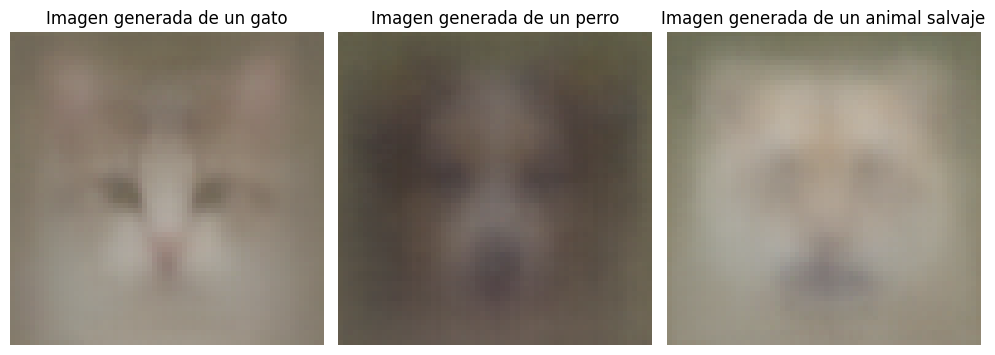

In [40]:
plt.figure(figsize=(10 ,5))
plt.subplot(1 ,3 ,1)
plt.imshow((generated_cat_image_2 +1) / 2)
plt.title('Imagen generada de un gato')
plt.axis('off')

plt.subplot(1 ,3 ,2)
plt.imshow((generated_dog_image_2 +1) / 2)
plt.title('Imagen generada de un perro')
plt.axis('off')

plt.subplot(1 ,3 ,3)
plt.imshow((generated_wild_image_2 + 1) / 2)
plt.title('Imagen generada de un animal salvaje')
plt.axis('off')

plt.tight_layout()

plt.show()